In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy
from scipy.stats import norm, mannwhitneyu
import json
from tqdm.auto import tqdm

In [2]:
# Настройки графиков
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [3]:
# Ссылка на csv на моем яндекс-диске
url = 'https://disk.yandex.ru/d/FZTM5asX1huY8w'

In [4]:
# Подготовка ссылки для загрузки в датафрейм
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=url))
response = requests.get(final_url)
download_url = response.json()['href']

In [5]:
# Загружаем оригинальный датасет
original_df = pd.read_csv(download_url, parse_dates=['event_datetime', 'event_receive_datetime'])

In [6]:
# Распарсим значения колонки event_json 
df = original_df.join(original_df['event_json'].apply(json.loads).apply(pd.Series))

In [7]:
# Удаляем уже ненужную колонку event_json
df = df.drop(columns={'event_json'})

In [8]:
# Заполняем отсутствующие данные по городу пользователя на undefined
df.city = df.city.fillna('undefined')

In [9]:
# Выводим минимальную дату ивента, чтобы понять временной диапазон датасета
df.event_datetime.min()

Timestamp('2022-01-29 17:42:32')

In [10]:
# Крайняя дата ивента датасета. Т.е. всего порядка 9 дней
df.event_datetime.max()

Timestamp('2022-02-07 23:59:59')

#### Для каждого формата рекламы: 
построить распределение средних eCPM-ов юзеров

In [11]:
# Создаем колонку с расчетом значений eCPM (revenue * 1000)
df['ecpm'] = df.revenue * 1000

In [12]:
# Смотрим количество рекламных ивентов в датасете по типу (формату)
df.ad_type.value_counts()

banner    815984
int        37613
rv          6482
Name: ad_type, dtype: int64

In [13]:
# Создаем вспомогательные датасеты (с фильтрацией по типу рекламы) для постройки графиков
# Рассчитывае средние значения eCPM для пользователей
banner_mean_ecpm = df.query('ad_type == "banner"') \
                        .groupby('profile_id', as_index=False) \
                        .agg({'ecpm': 'mean'}) \
                        .rename(columns={'ecpm': 'mean_ecpm'})
int_mean_ecpm = df.query('ad_type == "int"') \
                        .groupby('profile_id', as_index=False) \
                        .agg({'ecpm': 'mean'}) \
                        .rename(columns={'ecpm': 'mean_ecpm'})
rv_mean_ecpm = df.query('ad_type == "rv"') \
                        .groupby('profile_id', as_index=False) \
                        .agg({'ecpm': 'mean'}) \
                        .rename(columns={'ecpm': 'mean_ecpm'})

In [14]:
# T-тест говорит о наличии статзначимых отличиях в выборках средних между rv и int (p-value < 0.05)
scipy.stats.ttest_ind(int_mean_ecpm.mean_ecpm, rv_mean_ecpm.mean_ecpm)

Ttest_indResult(statistic=-19.411411633016986, pvalue=3.9052714921988233e-81)

In [15]:
# Проводим непараметрический тест Мана-Уитни
# Аналогично: p_value < 0.05 говорит о том, что есть значимые различия в выборках
stat, p = mannwhitneyu(int_mean_ecpm.mean_ecpm, rv_mean_ecpm.mean_ecpm)
stat, p

(1681940.0, 2.667707107101609e-85)

In [16]:
# Тест Левена: дисперсии негомогенны (p-value < 0.05), значит дисперсионный анализ проводить некорректно
scipy.stats.levene(int_mean_ecpm.mean_ecpm, rv_mean_ecpm.mean_ecpm, banner_mean_ecpm.mean_ecpm)

LeveneResult(statistic=1005.473015693256, pvalue=0.0)

/Users/nekrasov.sd/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


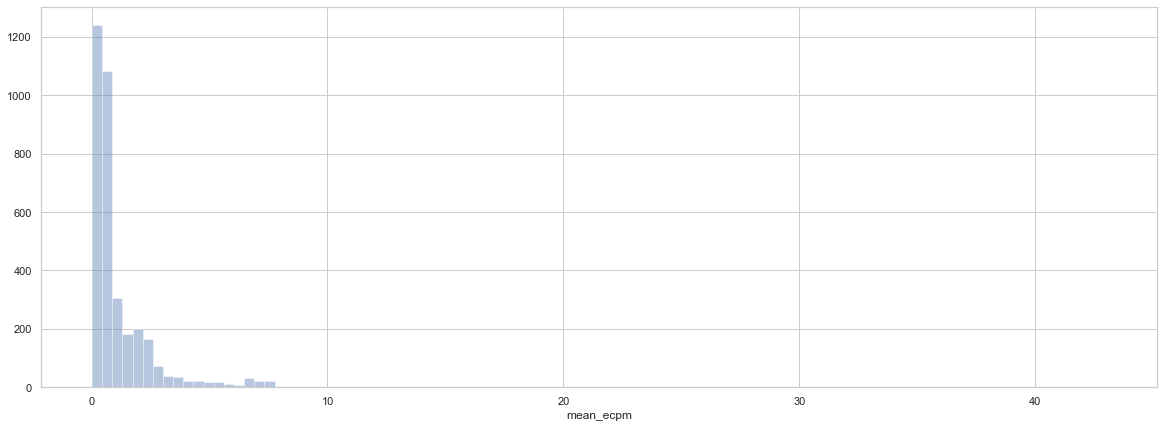

In [17]:
# Строим график распределения средних ecpm в формате "banner"
banner_ax = sns.distplot(banner_mean_ecpm.mean_ecpm, bins=100, kde=False)

In [18]:
# Выведем числовое описание распределения средних значений eCPM по баннерам
banner_mean_ecpm.describe()

,mean_ecpm
count,3508.000000
mean,1.157111
std,1.867792
min,0.013930
25%,0.322804
50%,0.583002
75%,1.297329
max,43.021387


In [19]:
# распределение ненормальное по тесту Шапиро-Уилка (p < 0.05)
scipy.stats.shapiro(banner_mean_ecpm.mean_ecpm.sample(1000, random_state=17))

ShapiroResult(statistic=0.41900956630706787, pvalue=0.0)

Видим, что распределение смещено сильно влево. \
Среднее eCPM = 1.157, медиана = 0.58 \
Также отмечаем выбросы значений eCPM до 43 

/Users/nekrasov.sd/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


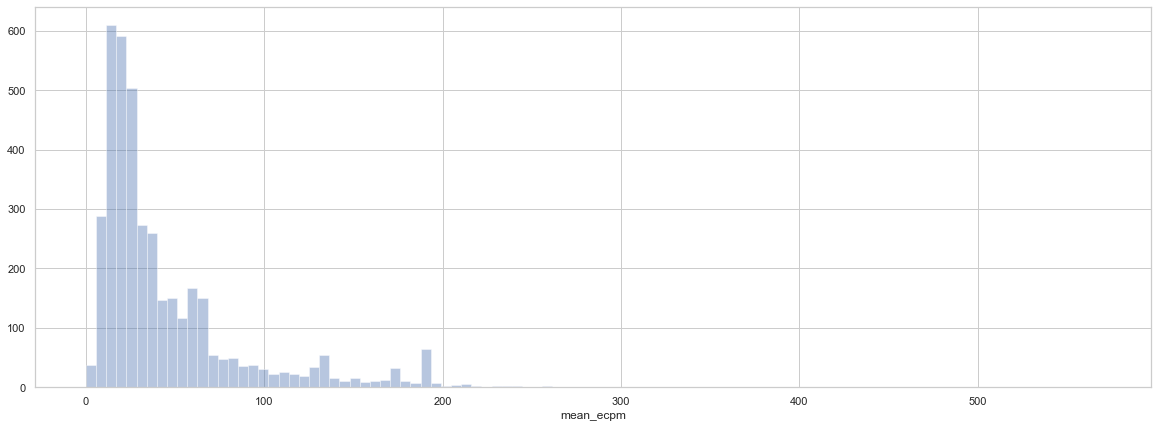

In [20]:
# Строим график распределения средних ecpm в формате полноэкранной рекламы
int_ax = sns.distplot(int_mean_ecpm.mean_ecpm, bins=100, kde=False)

In [21]:
# Выведем числовое описание распределения средних значений ecpm по полноэкранной рекламе
int_mean_ecpm.describe()

,mean_ecpm
count,3962.000000
mean,45.557457
std,46.877344
min,0.000000
25%,17.620615
50%,27.623670
75%,56.397665
max,568.678270


In [22]:
# распределение ненормальное по тесту Шапиро-Уилка (p < 0.05)
scipy.stats.shapiro(int_mean_ecpm.mean_ecpm.sample(1000, random_state=17))

ShapiroResult(statistic=0.7298945188522339, pvalue=2.188546820543728e-37)

Распределение выглядит более нормальным, но также с перекосом влево. \
Среднее eCPM = 45.56, медиана = 27.62 \
Есть также значительные выбросы до 568

/Users/nekrasov.sd/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


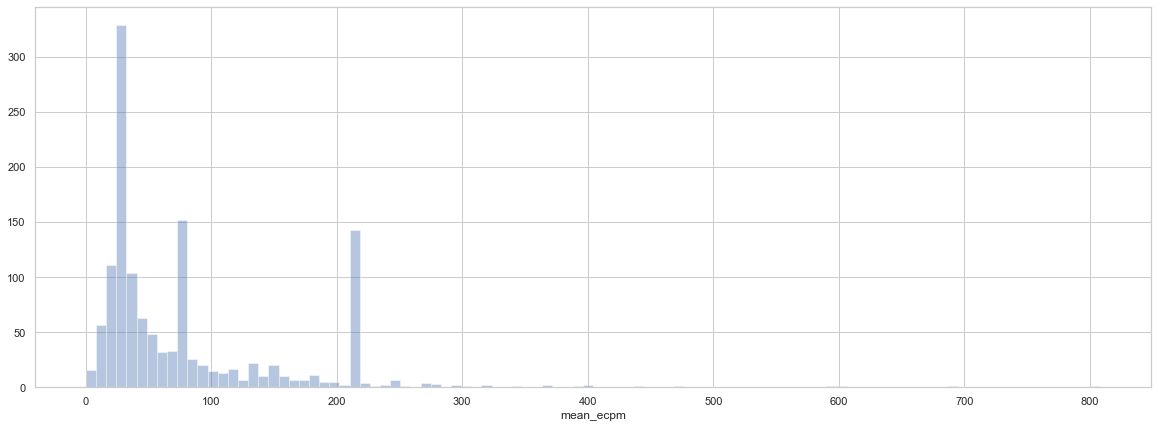

In [23]:
# Строим график распределения средних ecpm в формате просмотра видео
rv_ax = sns.distplot(rv_mean_ecpm.mean_ecpm, bins=100, kde=False)

In [24]:
# Выведем числовое описание распределения средних значений ecpm по запущенным видео
rv_mean_ecpm.describe()

,mean_ecpm
count,1324.000000
mean,80.502004
std,79.154906
min,0.223222
25%,28.240000
50%,46.019935
75%,98.067206
max,808.294820


In [25]:
# распределение ненормальное по тесту Шапиро-Уилка (p < 0.05)
scipy.stats.shapiro(rv_mean_ecpm.mean_ecpm.sample(1000, random_state=17))

ShapiroResult(statistic=0.7443526983261108, pvalue=1.2403712859704156e-36)

Распределение имеет несколько мод: приблизительно на значениях 30, 80 и 210 (возможно связано с кол-вом рекламных видео после уровней и соответственно прогресса прохождения игры) \
Среднее eCPM = 80.5, медиана = 39.86 \
Есть также значительные выбросы до 808

In [26]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    u_test = mannwhitneyu(samples_1, samples_2)    
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value,
            "u_test": u_test}

  0%|          | 0/2000 [00:00<?, ?it/s]

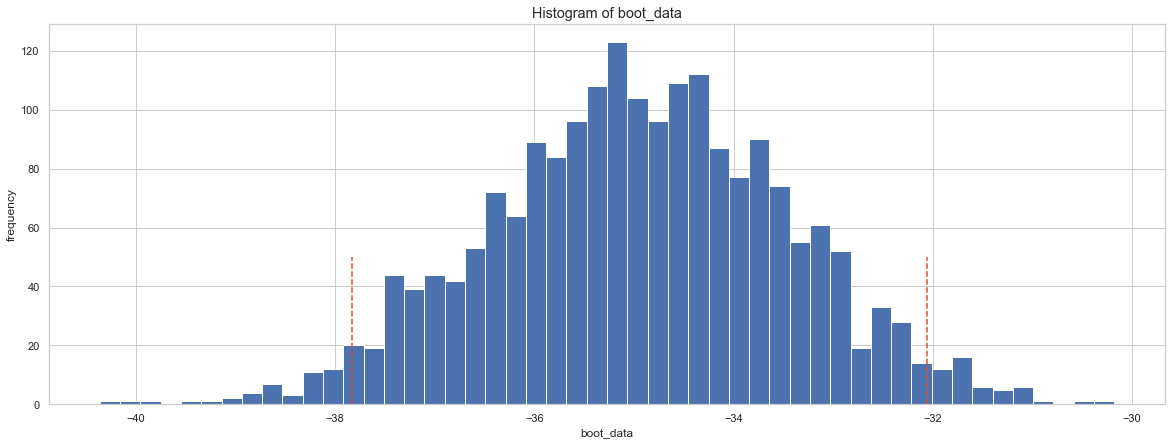

In [27]:
# в результате хранится разница двух распределений, доверительный интервал и pvalue для bootstrap по медианам между rv и int 
booted_data_mean_rv_int = get_bootstrap(int_mean_ecpm.mean_ecpm, 
                                 rv_mean_ecpm.mean_ecpm,
                                 boot_it = 2000, 
                                 statistic = np.mean)

In [28]:
# p_value для bootstrap по разницам значений средних int и rv
# можно считать статистически значимыми различия между группами (p_value < 0.05)
booted_data_mean_rv_int["p_value"]

2.8470037638960793e-121

In [29]:
# То же самое, но через непараметрический u-тест Мана-Уитни
# Значение p-value (< 0.05) говорит о том, что есть значимые отличия выборок rv и int
booted_data_mean_rv_int['u_test']

MannwhitneyuResult(statistic=4865835.5, pvalue=1.0107499851206446e-188)

Этими тестами показал, что есть статистически важные отличия по eCPM в зависимости от формата рекламы. \
Можно конечно проверить (вывести) также пары banner с rv и int, но они еще больше различаются.

In [30]:
# Доход в разбивке по формату рекламы
df.groupby('ad_type', as_index=False).agg({'revenue': 'sum'})

,ad_type,revenue
0,banner,607.184041
1,int,1361.952967
2,rv,421.661652


Общий вывод: эффективность привлечения прибыли от показов видео значительно выше показов полноэкранной рекламы(~ в 2 раза) и тем более баннеров (~ в 70 раз). \
\
*Я как пользователь (пусть и редкий) мобильных игр могу сказать свое мнение: баннеры раздражают - экран и так небольшой и лишний шум не добавляет дополнительной ценности игре. \
С другой стороны мы видим, что баннеры при низкой эффективности приносят значимую долю дохода. Следовательно надо искать баланс (проводить А/Б тесты) по количеству баннерной и других реклам, пользовательским метрикам, прибыли.

#### Для каждого формата рекламы: 
 построить распределение eCPM-ов по городам, версиям ОС \
 построить распределение доходов по городам, версиям ОС


In [31]:
# Видим, что большинство пользователей пользуются все таки свежими версиями прошивок
# Оставим версии от 9 и выше т.к. оставшаяся часть составляет чуть более 3% пользователей
df.os_version.value_counts(normalize=True)

12       0.473895
11       0.243083
10       0.175415
9        0.077507
8.1.0    0.010754
8.0.0    0.009320
7.0      0.004717
7.1.2    0.002106
7.1.1    0.001560
5.0.2    0.000824
6.0.1    0.000819
Name: os_version, dtype: float64

In [32]:
# Создаем список нужных os  и применим фильтры
wanted_os = ['9', '10', '11', '12']
city_os_ecpm = df[{'profile_id', 'city', 'ad_type', 'os_version', 'ecpm', 'revenue'}] \
        .query('os_version == @wanted_os')
# переведем формат названия прошивки в числовой для корректной сортировки
city_os_ecpm.os_version = city_os_ecpm.os_version.apply(int)

In [33]:
# Cоздаем вспомогательные датасеты с сортировкой по формату рекламы
banner_os = city_os_ecpm.query('ad_type == "banner"')
int_os = city_os_ecpm.query('ad_type == "int"')
rv_os = city_os_ecpm.query('ad_type == "rv"')

In [34]:
# Cоздаем вспомогательные датасеты-счетчики количества пользователей по городам и ОС (совместно)
banner_user_count = banner_os.groupby(['city', 'os_version'])['profile_id'].nunique()
banner_revenue = banner_os.groupby(['city', 'os_version'], as_index=False).agg({'revenue': 'sum'})

int_user_count = int_os.groupby(['city', 'os_version'])['profile_id'].nunique()
int_revenue = int_os.groupby(['city', 'os_version'], as_index=False).agg({'revenue': 'sum'})

rv_user_count = rv_os.groupby(['city', 'os_version'])['profile_id'].nunique()
rv_revenue =rv_os.groupby(['city', 'os_version'], as_index=False).agg({'revenue': 'sum'})

In [35]:
# Cоздаем вспомогательные датасеты-счетчики количества пользователей по городам
banner_user_count_by_city = banner_os.groupby('city')['profile_id'].nunique()
int_user_count_by_city = int_os.groupby('city')['profile_id'].nunique()
rv_user_count_by_city = rv_os.groupby('city')['profile_id'].nunique()

In [36]:
# Соединяем датасеты со счетчиками пользователей
# Рассчитываем ARPU для кластеров город/версия ОС для каждого вида рекламы
banner_os = banner_os.merge(banner_user_count, how='left', on=['city', 'os_version']) \
            .merge(banner_revenue, how='left', on=['city', 'os_version']) \
            .rename(columns={'profile_id_x': 'profile_id', \
                             'profile_id_y': 'user_count', \
                             'revenue_x': 'revenue', \
                             'revenue_y': 'revenue_sum'})
# мердж счетчика по городам
banner_os = banner_os.merge(banner_user_count_by_city, how='left', on='city') \
                    .rename(columns={'profile_id_x': 'profile_id', \
                             'profile_id_y': 'user_count_by_city'})
# создаем колонку с расчетом arpu для кластеров
banner_os['arpu'] = banner_os.revenue_sum / banner_os.user_count

int_os = int_os.merge(int_user_count, how='left', on=['city', 'os_version']) \
            .merge(int_revenue, how='left', on=['city', 'os_version']) \
            .rename(columns={'profile_id_x': 'profile_id', \
                             'profile_id_y': 'user_count', \
                             'revenue_x': 'revenue', \
                             'revenue_y': 'revenue_sum'})
# мердж счетчика по городам
int_os = int_os.merge(int_user_count_by_city, how='left', on='city') \
                    .rename(columns={'profile_id_x': 'profile_id', \
                             'profile_id_y': 'user_count_by_city'})
# создаем колонку с расчетом arpu для кластеров
int_os['arpu'] = int_os.revenue_sum / int_os.user_count

rv_os = rv_os.merge(rv_user_count, how='left', on=['city', 'os_version']) \
            .merge(rv_revenue, how='left', on=['city', 'os_version']) \
            .rename(columns={'profile_id_x': 'profile_id', \
                             'profile_id_y': 'user_count', \
                             'revenue_x': 'revenue', \
                             'revenue_y': 'revenue_sum'})
# мердж счетчика по городам
rv_os = rv_os.merge(rv_user_count_by_city, how='left', on='city') \
                    .rename(columns={'profile_id_x': 'profile_id', \
                             'profile_id_y': 'user_count_by_city'})
# создаем колонку с расчетом arpu для кластеров
rv_os['arpu'] = rv_os.revenue_sum / rv_os.user_count

Text(0.5, 1.0, 'Баннеры: средние eCPM с разбивкой по ОС')

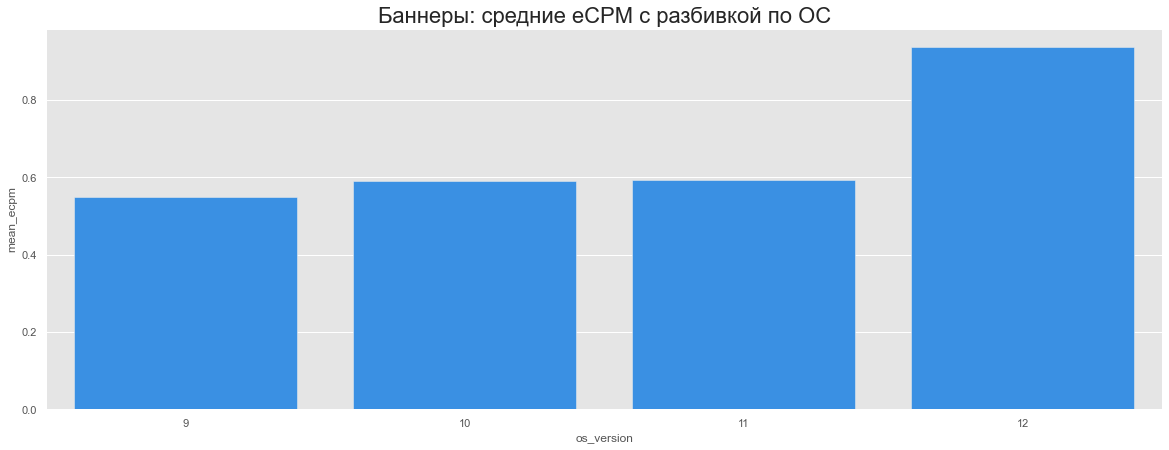

In [37]:
# Строим барплот средних eCPM с разбивкой по ОС для banner
banner_os_ax = banner_os.groupby('os_version', as_index=False) \
                        .agg({'ecpm': 'mean'}) \
                        .rename(columns={'ecpm':'mean_ecpm'})
sns.barplot(data=banner_os_ax, x="os_version", y="mean_ecpm", color="dodgerblue")
plt.title('Баннеры: средние eCPM с разбивкой по ОС', fontsize=22)

Text(0.5, 1.0, 'Полноэкранная реклама: средние eCPM с разбивкой по ОС')

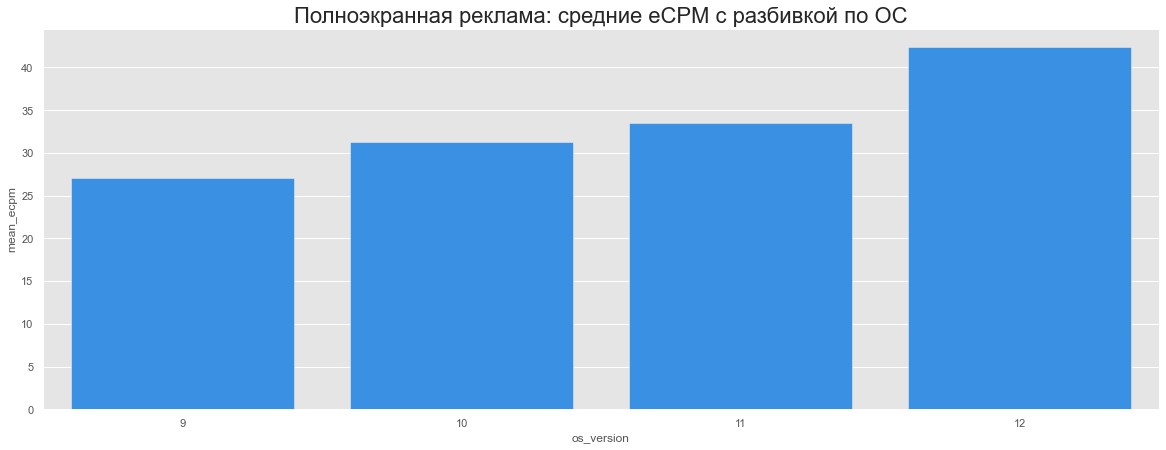

In [38]:
# Строим барплот средних eCPM с разбивкой по ОС для int
int_os_ax = int_os.groupby('os_version', as_index=False)\
                        .agg({'ecpm': 'mean'}) \
                        .rename(columns={'ecpm':'mean_ecpm'})
sns.barplot(data=int_os_ax, x="os_version", y="mean_ecpm", color="dodgerblue")
plt.title('Полноэкранная реклама: средние eCPM с разбивкой по ОС', fontsize=22)

Text(0.5, 1.0, 'Видео: средние eCPM с разбивкой по ОС')

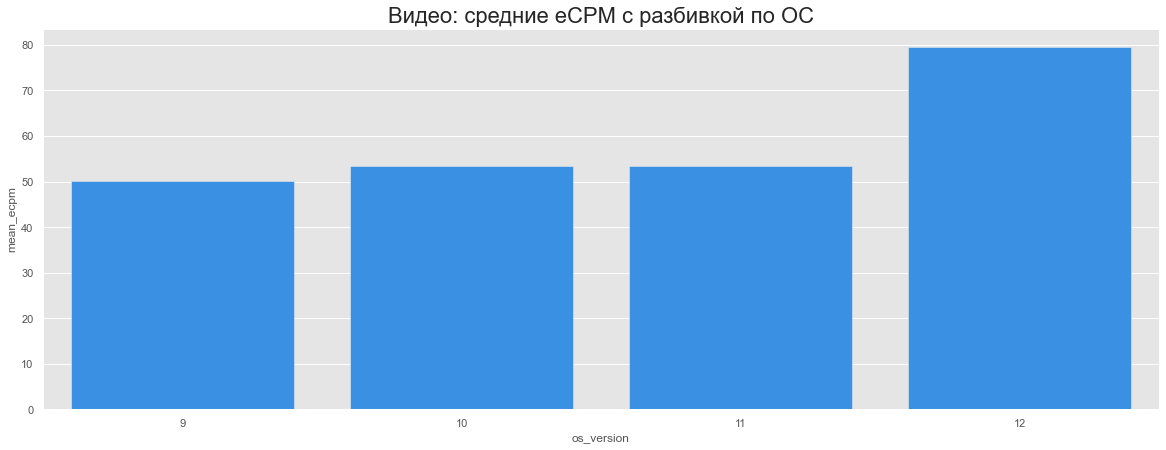

In [39]:
# Строим барплот средних eCPM с разбивкой по ОС для rv
rv_os_ax = rv_os.groupby('os_version', as_index=False) \
                        .agg({'ecpm': 'mean'}) \
                        .rename(columns={'ecpm':'mean_ecpm'})
sns.barplot(data=rv_os_ax, x="os_version", y="mean_ecpm", color="dodgerblue")
plt.title('Видео: средние eCPM с разбивкой по ОС', fontsize=22)

#### Вывод: 
для всех форматов рекламы характерен рост eCPM в зависимости от версии ОС (чем новее ОС, тем выше)

Text(0.5, 1.0, 'Баннеры: средние eCPM с разбивкой по городам')

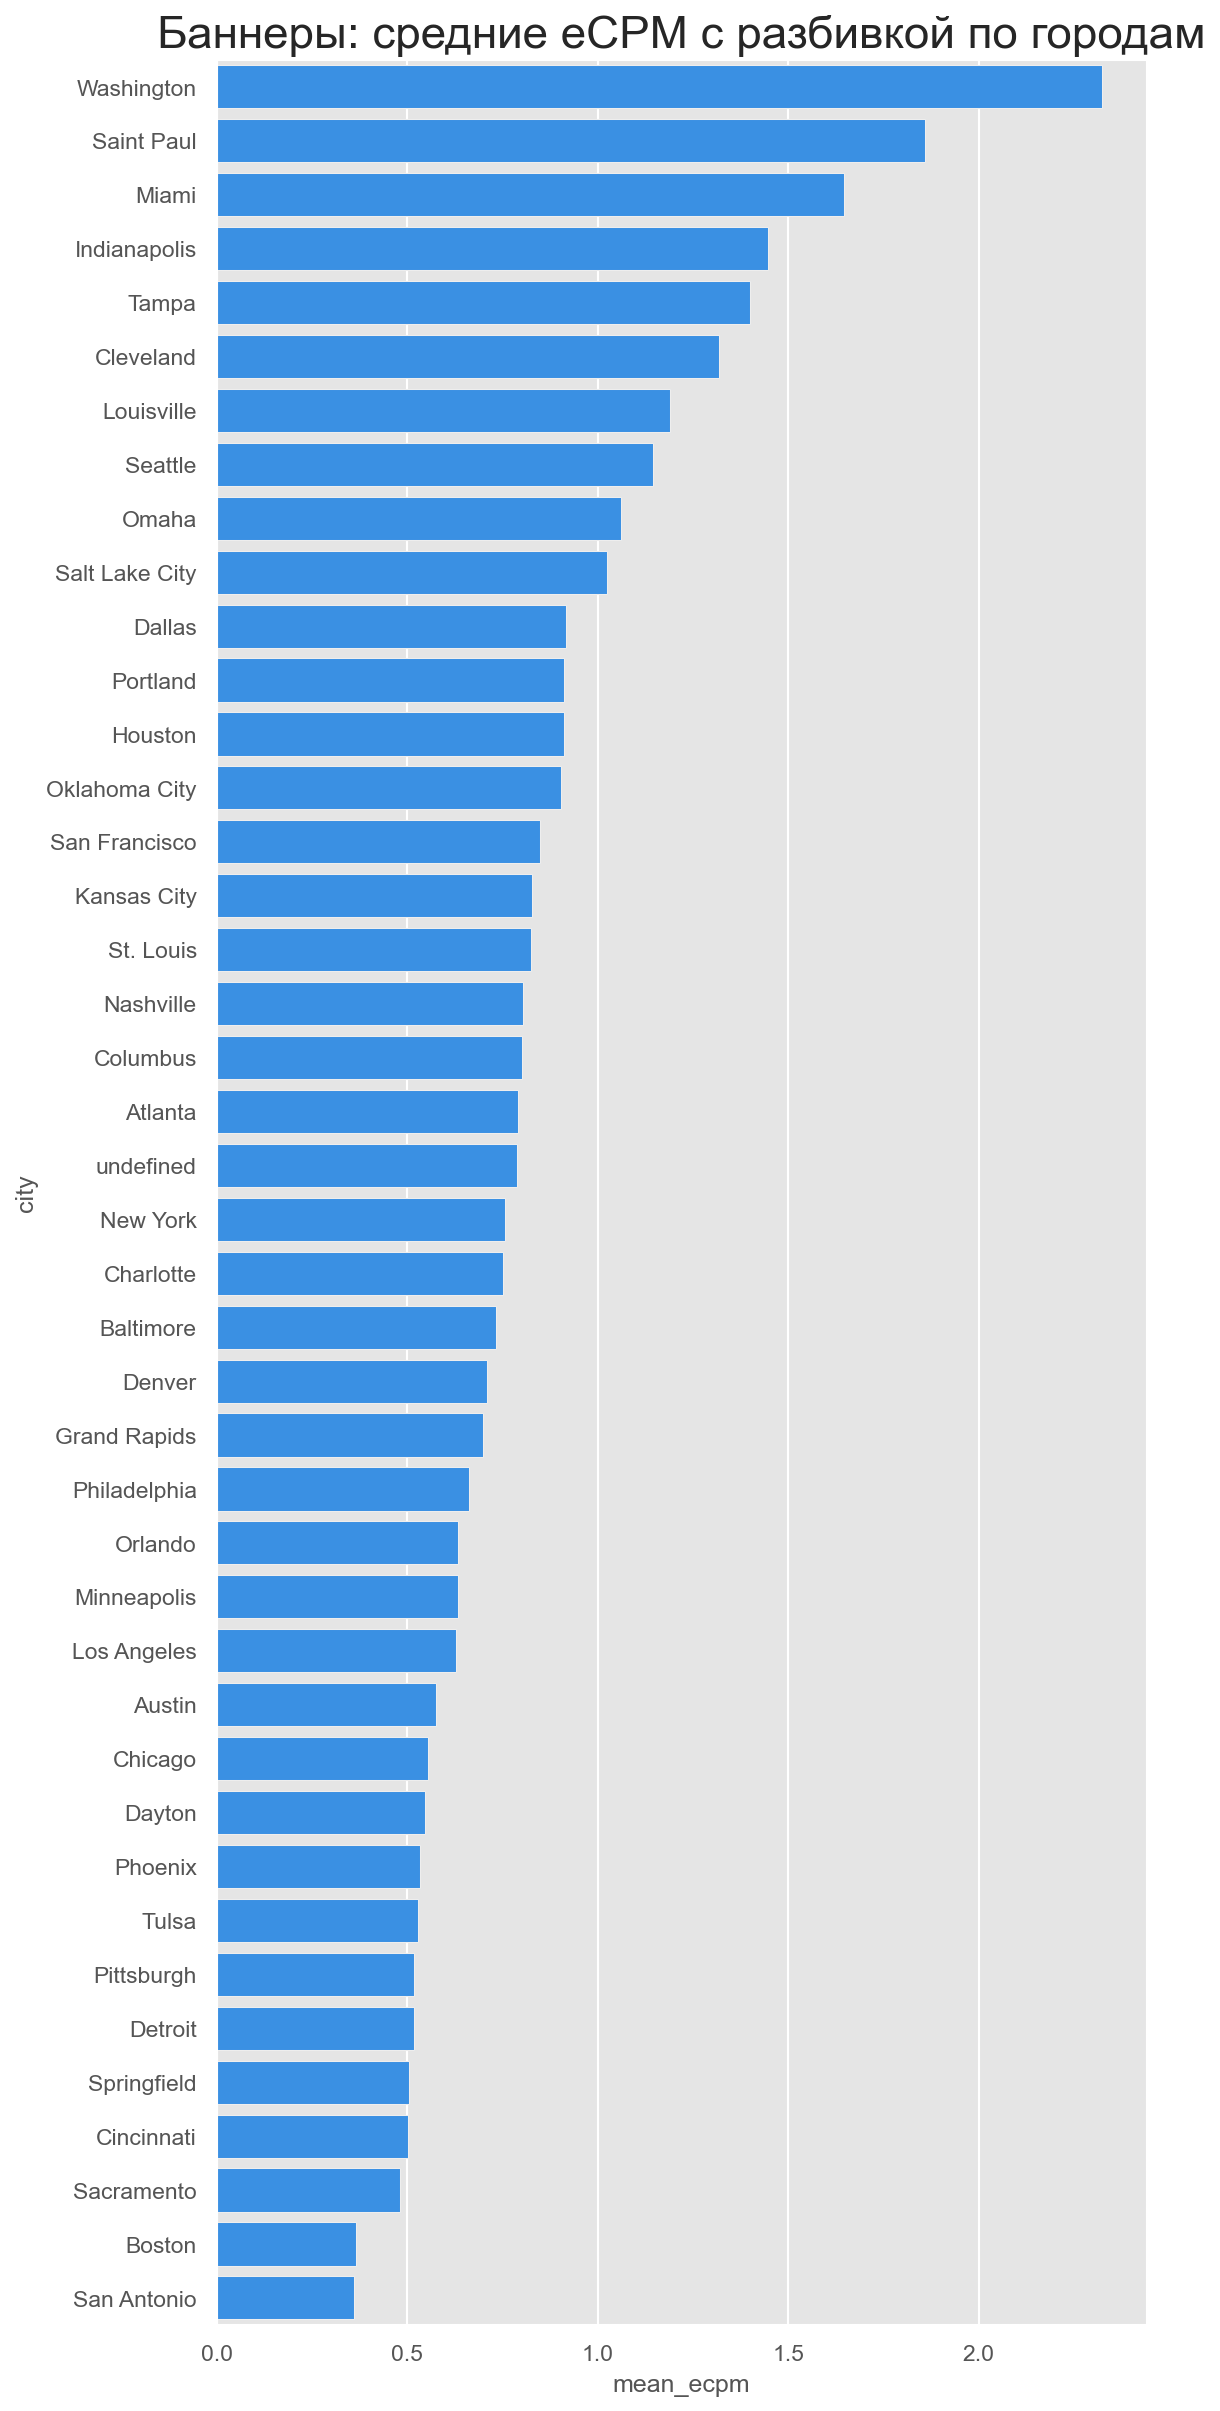

In [40]:
# Оставим только города с более 15 активными юзерами (проявивших активность в периоде)
# Строим барплот средних eCPM с разбивкой по городам
banner_city_ax = banner_os.query('user_count_by_city >= 15')\
                        .groupby('city', as_index=False) \
                        .agg({'ecpm': 'mean'}) \
                        .rename(columns={'ecpm':'mean_ecpm'}) \
                        .sort_values('mean_ecpm', ascending=False) \
                        .head(50)
plt.figure(figsize=(8,20), dpi= 150)
sns.barplot(data=banner_city_ax, y="city", x="mean_ecpm", color="dodgerblue", orient='h')
plt.title('Баннеры: средние eCPM с разбивкой по городам', fontsize=22)

Text(0.5, 1.0, 'Полноэкранная реклама: средние eCPM с разбивкой по городам')

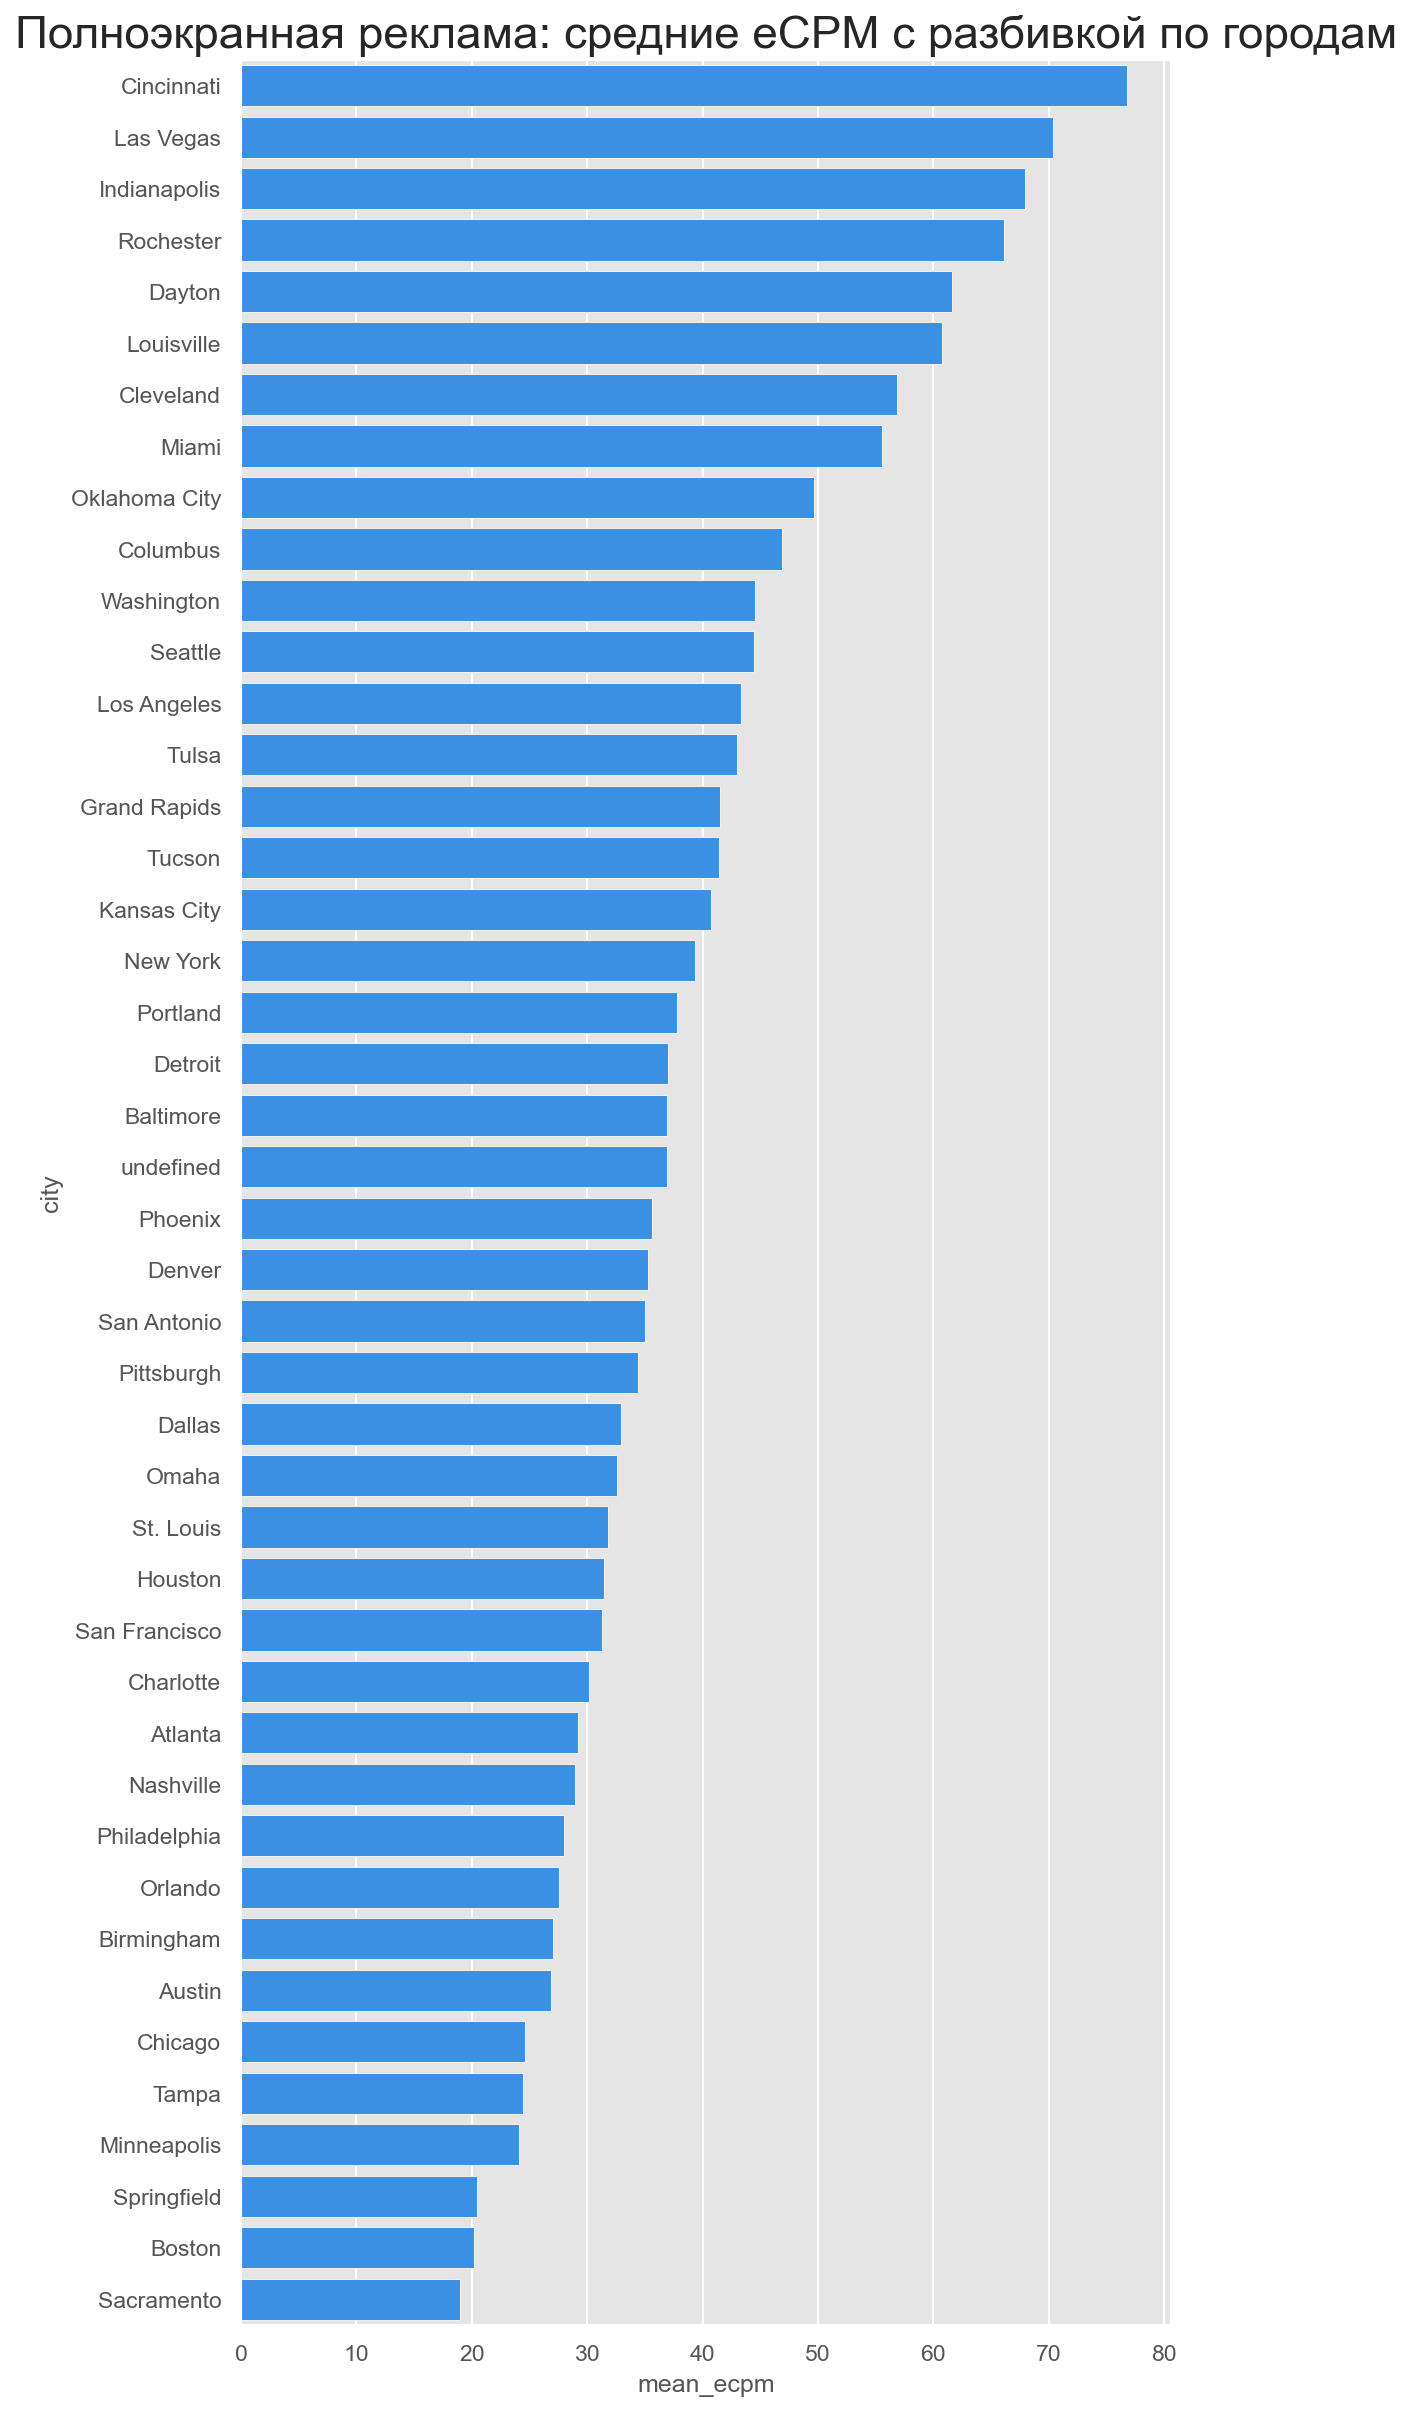

In [41]:
# Оставим только города с более 15 активными юзерами (проявивших активность в периоде)
# Строим барплот средних eCPM с разбивкой по городам
int_city_ax = int_os.query('user_count_by_city >= 15')\
                        .groupby('city', as_index=False) \
                        .agg({'ecpm': 'mean'}) \
                        .rename(columns={'ecpm':'mean_ecpm'}) \
                        .sort_values('mean_ecpm', ascending=False) \
                        .head(50)
plt.figure(figsize=(8,20), dpi= 150)
sns.barplot(data=int_city_ax, y="city", x="mean_ecpm", color="dodgerblue", orient='h')
plt.title('Полноэкранная реклама: средние eCPM с разбивкой по городам', fontsize=22)

Text(0.5, 1.0, 'Видео-реклама: средние eCPM с разбивкой по городам')

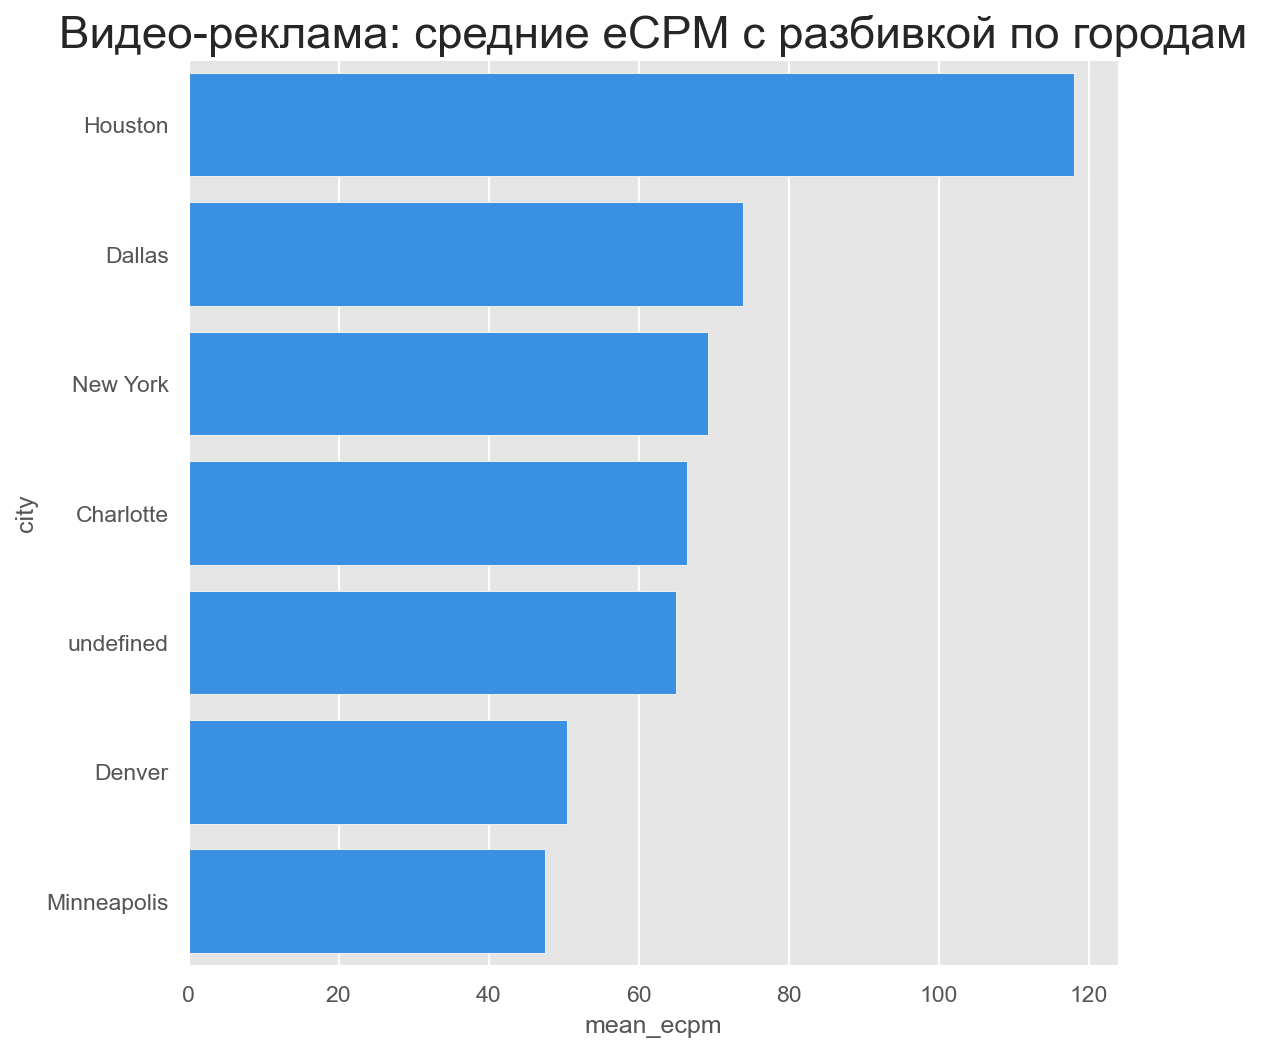

In [42]:
# Оставим только города с более 15 активными юзерами (проявивших активность в периоде)
# Строим барплот средних eCPM с разбивкой по городам
rv_city_ax = rv_os.query('user_count_by_city >= 15')\
                        .groupby('city', as_index=False) \
                        .agg({'ecpm': 'mean'}) \
                        .rename(columns={'ecpm':'mean_ecpm'}) \
                        .sort_values('mean_ecpm', ascending=False) \
                        .head(50)
plt.figure(figsize=(8,8), dpi= 150)
sns.barplot(data=rv_city_ax, y="city", x="mean_ecpm", color="dodgerblue", orient='h')
plt.title('Видео-реклама: средние eCPM с разбивкой по городам', fontsize=22)

#### Вывод:
Какой-либо корреляции между форматами рекламы и значениями средних eCPM по городам на первый взгляд не просматривается. И это даже хорошо! Есть над чем поработать - можно таргетировать формат рекламы в зависимости от города юзера и получать больший доход!

Дальше попробуем сделать поинтересней: попробуем сделать кластеры по городам и ОС и посмотреть как распределяются eCPM и ARPU

In [43]:
# Видим что распределение очень неравномерное. Большая часть всех пользователей единичны для разных городов
banner_os.groupby('city')['profile_id'].nunique().describe()

count     842.000000
mean        5.222090
std        52.220395
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max      1505.000000
Name: profile_id, dtype: float64

In [44]:
# Оставляем только данные где пользователей больше или равно 15 (минимум для сравнения выборок)
# желательно больше, но данных не так много
banner_os_ecpm = banner_os.query('user_count >= 15') \
                          .groupby(['os_version', 'city'], as_index=False) \
                          .agg({'ecpm': 'mean'})

In [45]:
# Тоже самое подготовим для графика arpu
banner_os_arpu = banner_os.query('user_count >= 15')

In [46]:
# Создаем pivot датасет для построения heatmap ecpm
banner_os_ecpm_pivot = banner_os_ecpm \
                      .pivot(index = 'city', columns = 'os_version', values = 'ecpm')

In [47]:
# Создаем pivot датасет для построения heatmap arpu
banner_os_arpu_pivot = banner_os_arpu[{'city', 'os_version', 'arpu'}] \
                    .drop_duplicates() \
                    .pivot(index = 'city', columns = 'os_version', values = 'arpu')

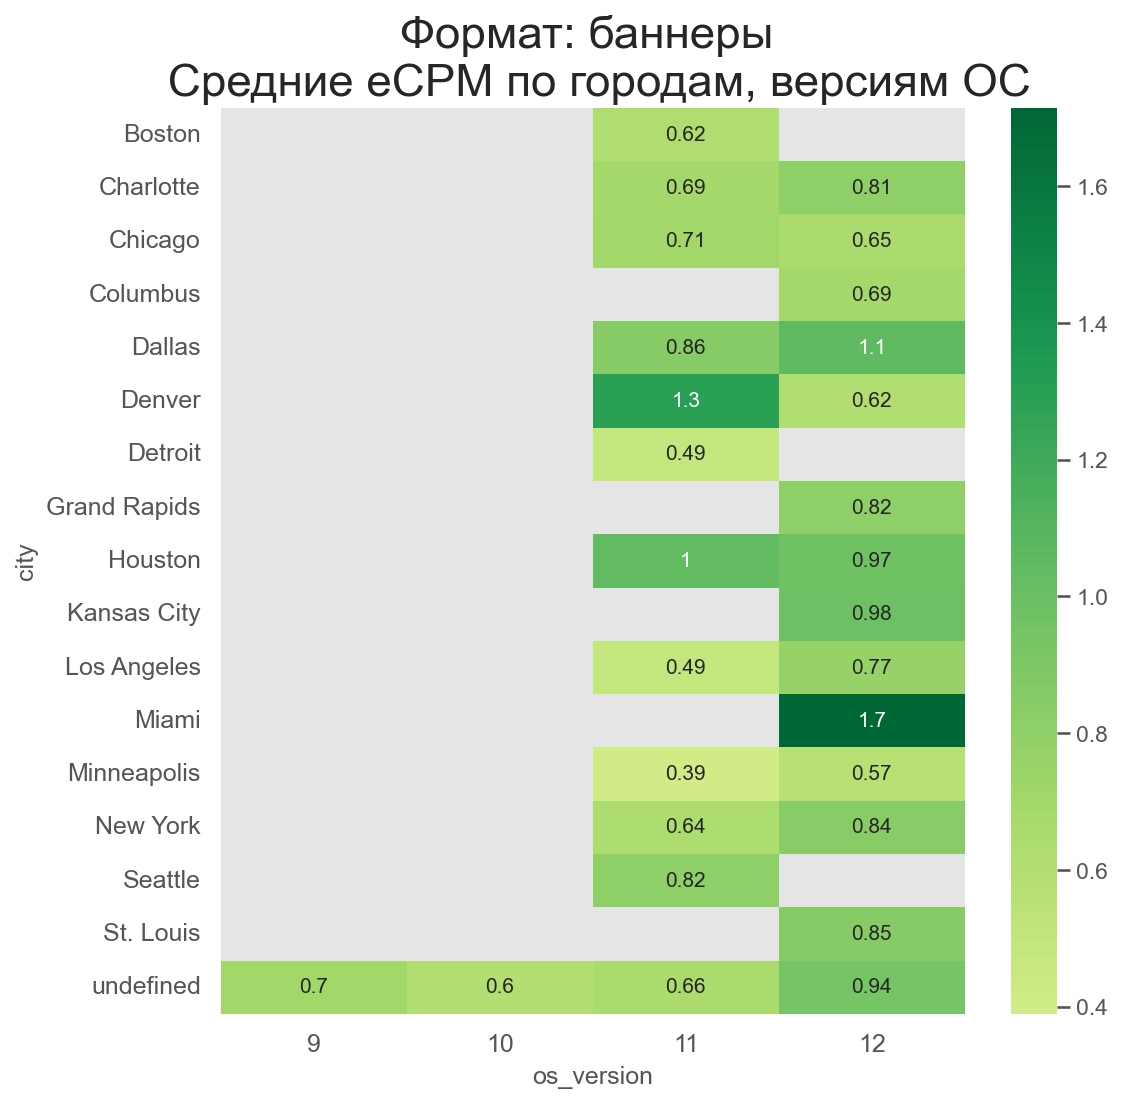

In [48]:
# Cтроим heatmap взаимосвязи города, версии ОС и медианных значений ecpm для banner
plt.figure(figsize=(8,8), dpi= 150)
banner_ecpm_heatmap = sns.heatmap(banner_os_ecpm_pivot, cmap='RdYlGn', center=0, annot=True)
plt.title('Формат: баннеры \n Средние eCPM по городам, версиям ОС', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

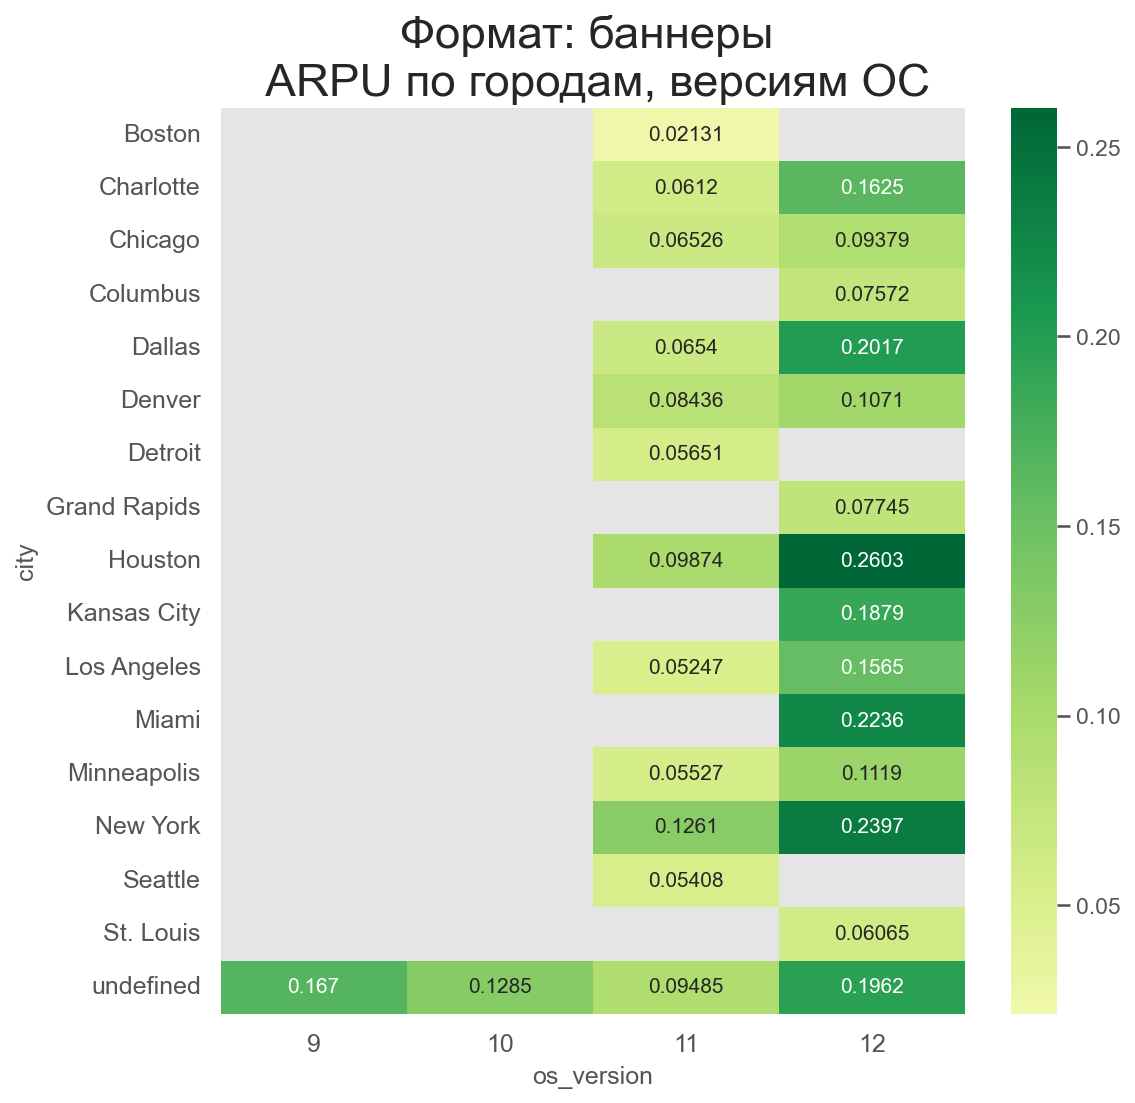

In [49]:
# Cтроим heatmap взаимосвязи города, версии ОС и ARPU для banner
plt.figure(figsize=(8,8), dpi= 150)
banner_arpu_heatmap = sns.heatmap(banner_os_arpu_pivot, cmap='RdYlGn', center=0, annot=True, fmt='.4g')
plt.title('Формат: баннеры \n ARPU по городам, версиям ОС', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [50]:
# Видим что распределение очень неравномерное. Большая часть всех пользователей единичны для разных городов
int_os.groupby('city')['profile_id'].nunique().describe()

count     859.000000
mean        5.430733
std        55.929553
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max      1629.000000
Name: profile_id, dtype: float64

In [51]:
# Оставляем только данные где пользователей больше или равно 20 (минимум для сравнения выборок)
# желательно больше, но данных не так много
int_os_ecpm = int_os.query('user_count >= 15').groupby(['os_version', 'city'], as_index=False) \
    .agg({'ecpm': 'mean'})

In [52]:
# Тоже самое подготовим для графика arpu
int_os_arpu = int_os.query('user_count >= 15')

In [53]:
# Создаем pivot датасет для построения heatmap ecpm
int_os_ecpm_pivot = int_os_ecpm.pivot(index = 'city', columns = 'os_version', values = 'ecpm')

In [54]:
# Создаем pivot датасет для построения heatmap arpu
int_os_arpu_pivot = int_os_arpu[{'city', 'os_version', 'arpu'}] \
                    .drop_duplicates() \
                    .pivot(index = 'city', columns = 'os_version', values = 'arpu')

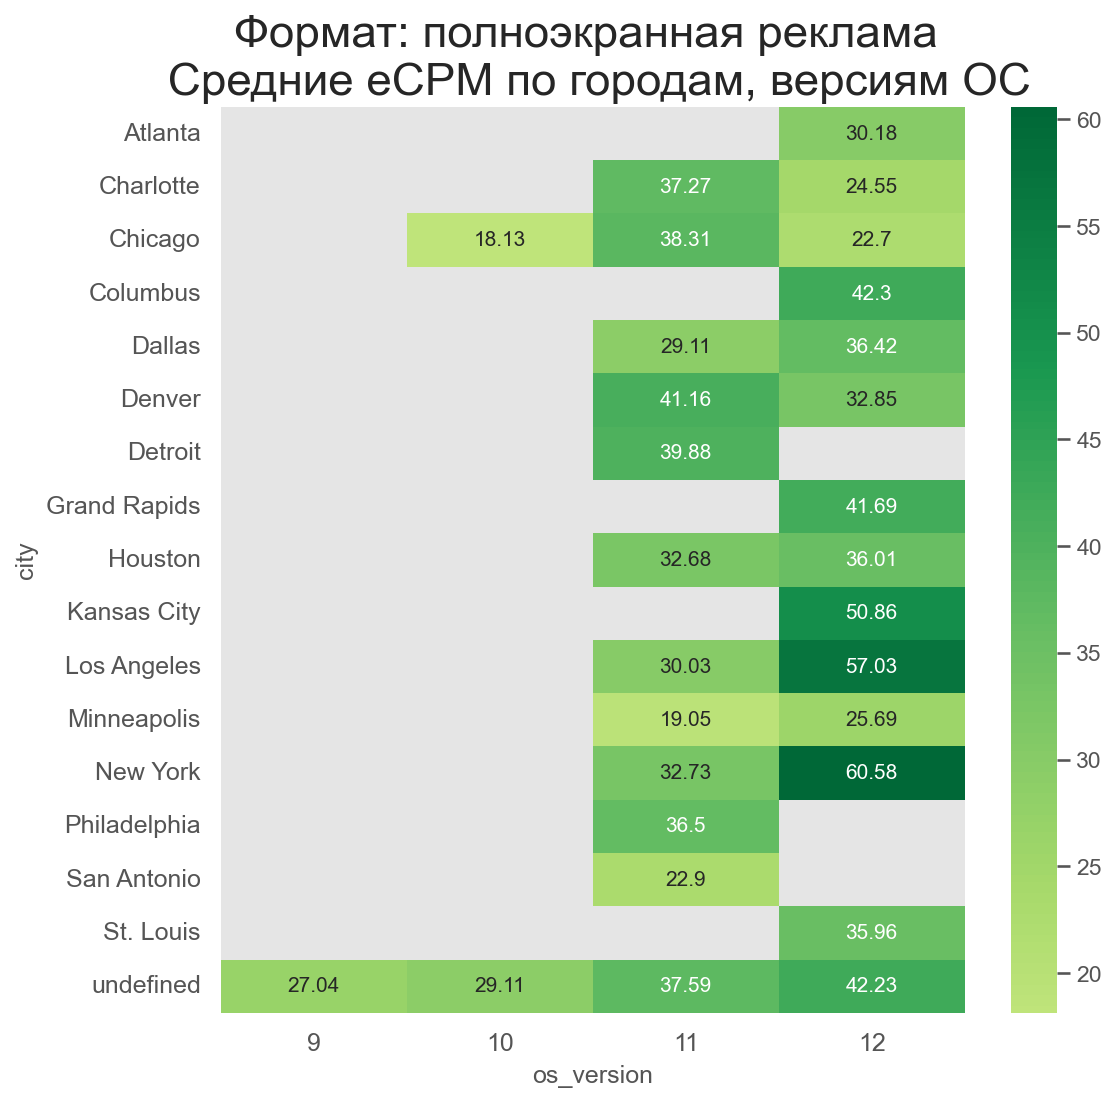

In [55]:
# Cтроим heatmap взаимосвязи города, версии ОС и медианных значений ecpm для int
plt.figure(figsize=(8,8), dpi= 150)
int_ecpm_heatmap = sns.heatmap(int_os_ecpm_pivot, cmap='RdYlGn', center=0, annot=True, fmt='.4g')
plt.title('Формат: полноэкранная реклама \n Средние eCPM по городам, версиям ОС', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

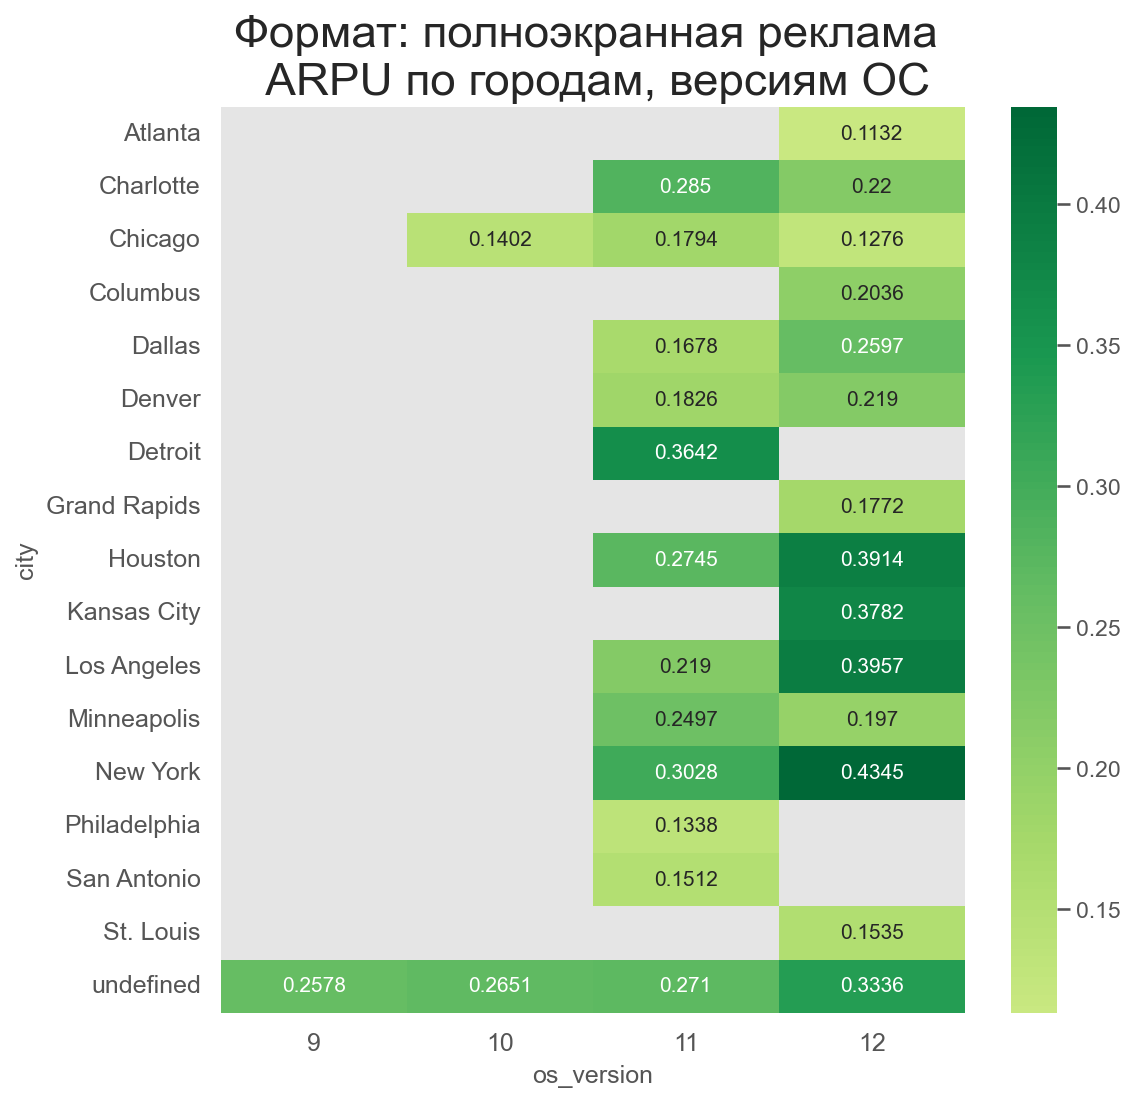

In [56]:
# Cтроим heatmap взаимосвязи города, версии ОС и ARPU для int
plt.figure(figsize=(8,8), dpi= 150)
int_arpu_heatmap = sns.heatmap(int_os_arpu_pivot, cmap='RdYlGn', center=0, annot=True, fmt='.4g')
plt.title('Формат: полноэкранная реклама \n ARPU по городам, версиям ОС', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [57]:
# Видим что распределение очень неравномерное. Большая часть всех пользователей единичны для разных городов
rv_os.groupby('city')['profile_id'].nunique().describe()

count    448.000000
mean       3.220982
std       24.164292
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      510.000000
Name: profile_id, dtype: float64

In [58]:
# Оставляем только данные где пользователей больше или равно 20 (минимум для сравнения выборок)
# желательно больше, но данных не так много
rv_os_ecpm = rv_os.query('user_count >= 10').groupby(['os_version', 'city'], as_index=False) \
    .agg({'ecpm': 'mean'})

In [59]:
# Тоже самое подготовим для графика arpu
rv_os_arpu = rv_os.query('user_count >= 10')

In [60]:
# Создаем pivot датасет для построения heatmap ecpm
rv_os_ecpm_pivot = rv_os_ecpm.pivot(index = 'city', columns = 'os_version', values = 'ecpm')

In [61]:
# Создаем pivot датасет для построения heatmap arpu
rv_os_arpu_pivot = rv_os_arpu[{'city', 'os_version', 'arpu'}] \
                    .drop_duplicates() \
                    .pivot(index = 'city', columns = 'os_version', values = 'arpu')

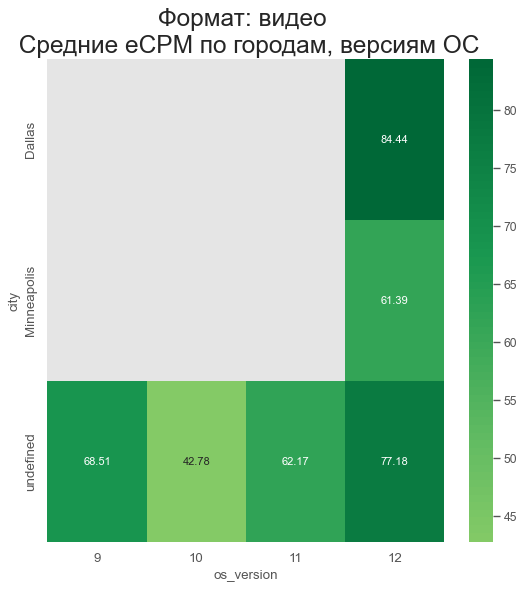

In [62]:
# Cтроим heatmap взаимосвязи города, версии ОС и медианных значений ecpm для rv
plt.figure(figsize=(8,8), dpi= 80)
rv_ecpm_heatmap = sns.heatmap(rv_os_ecpm_pivot, cmap='RdYlGn', center=0, annot=True, fmt='.4g')
plt.title('Формат: видео \n Средние eCPM по городам, версиям ОС', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

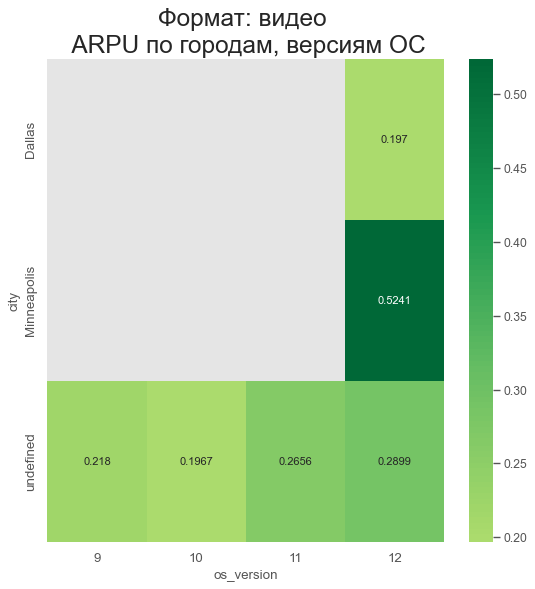

In [63]:
# Cтроим heatmap взаимосвязи города, версии ОС и ARPU для rv
plt.figure(figsize=(8,8), dpi= 80)
rv_arpu_heatmap = sns.heatmap(rv_os_arpu_pivot, cmap='RdYlGn', center=0, annot=True, fmt='.4g')
plt.title('Формат: видео \n ARPU по городам, версиям ОС', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### Вывод: так мы увидели, что есть разница между ОС устройств, городом, eCPM и доходом.
Эта инфрмация может позволить более эффективно выбирать формат рекламы в зависимости от версии ОС и географии юзера!

### Дополнительные (по желанию) 
Исследовать: \
– Какой процент доходов содержит информацию о городе юзера 

In [64]:
# Еще раз смотрим на пропущенные значения:
# 1. нет пропущенных revenue
# 2. помним что по городам мы заменили пропуски на 'undefined'
df.isna().sum()

profile_id                    14
os_version                     0
device_manufacturer            0
device_model                   0
device_type                    0
device_locale                  0
event_name                     0
event_datetime                 0
event_timestamp                0
event_receive_datetime         0
event_receive_timestamp        0
connection_type                0
operator_name              18879
country_iso_code               0
city                           0
ad_type                        0
placement                      0
view_index                     0
session_view_index             0
cur_ticks                      0
session_length                 0
revenue                        0
ads_ltv                        0
ecpm_sma                       0
normalized_ecpm_sma            0
value                          0
currency                       0
ad_country_code                0
network_name                   0
ad_unit_id                     0
ad_network

In [65]:
# Рассчитать процент доходов с информацией о городе юзера можно через фильтр и умножение на 100
# округлил до 3 знаков после запятой
round(100 - (df.query('city == "undefined"').shape[0] / df.shape[0]) * 100, 3)

62.363

In [66]:
# другой вариант
round(100 - df.city.value_counts(normalize=True)[0] * 100, 3)

62.363

Ответ: 62.363% доходов содержит информацию о городе юзера

### Дополнительные (по желанию) 
Исследовать: \
– Зависит ли eCPM от времени дня

In [67]:
ecpm_in_time = df[{'ad_type', 'event_datetime', 'ecpm', 'device_type'}]

In [68]:
# Помним что датасет начинается с вечера. 
# Чтобы коррктно распределить значения по часам, необходимо отсечь данные до '2022-01-29 23:59:59'
ecpm_in_time.event_datetime.min()

Timestamp('2022-01-29 17:42:32')

In [69]:
# отсекаем "лишние часы"
ecpm_in_time = ecpm_in_time.query('event_datetime > "2022-01-29 23:59:59"')

In [70]:
# проверяем
ecpm_in_time.event_datetime.min()

Timestamp('2022-01-30 01:45:29')

In [71]:
# Будем смотреть с разбивкой по часам, для этого приводим формат времени к часу
ecpm_in_time.event_datetime = x.event_datetime.dt.hour

NameError: name 'x' is not defined

In [ ]:
# Строим распределение значений средних eCPM по часам для баннеров
mean_ecpm_by_hour_banner = ecpm_in_time.query('ad_type == "banner"') \
            .groupby('event_datetime', as_index=False) \
            .agg({'ecpm': 'mean'}) \
            .rename(columns={'event_datetime': 'hour', 'ecpm': 'mean_ecpm'})
sns.barplot(data=mean_ecpm_by_hour_banner, x="hour", y="mean_ecpm", color="dodgerblue")
plt.title('Баннеры: средние eCPM с разбивкой по часам', fontsize=22)

In [ ]:
# Строим распределение значений средних eCPM по часам для полноэкранной рекламы
mean_ecpm_by_hour_int = ecpm_in_time.query('ad_type == "int"') \
            .groupby('event_datetime', as_index=False) \
            .agg({'ecpm': 'mean'}) \
            .rename(columns={'event_datetime': 'hour', 'ecpm': 'mean_ecpm'})
sns.barplot(data=mean_ecpm_by_hour_int, x="hour", y="mean_ecpm", color="dodgerblue")
plt.title('Полноэкранная реклама: средние eCPM с разбивкой по часам', fontsize=22)

In [ ]:
# Строим распределение значений средних eCPM по часам для видео
mean_ecpm_by_hour_rv = ecpm_in_time.query('ad_type == "int"') \
            .groupby('event_datetime', as_index=False) \
            .agg({'ecpm': 'mean'}) \
            .rename(columns={'event_datetime': 'hour', 'ecpm': 'mean_ecpm'})
sns.barplot(data=mean_ecpm_by_hour_rv, x="hour", y="mean_ecpm", color="dodgerblue")
plt.title('Видео: средние eCPM с разбивкой по часам', fontsize=22)

Вывод: динамика изменений ecpm для видео и полноэкранной рекламы сильно схожи. Есть пиковое значение на 13 часах дня (вероятно обеденное время), повышение утром и вечером но более сглаженные.
В целом та же тенденция с ecpm у баннеров, но выделяются другие часы (8 и 11)